## Лабораторная работа 2: Использование численных методов в задачах оптимизации

### 1. Поиск минимума функции:

\begin{align}
f(x)= \frac {1}{2} [ (x_ {1})^ {2} + \sum _ {i=1}^ {2} (x_ {i}-x_ {i+1})^ {2} + (x_ {3})^ {2} ]- x_ {1}
\end{align}


##### Представление применимости алгоритмов BFGS и L-BFGS к данной оптимизационной задаче

Чтобы обосновать корректность применения алгоритма BFGS к данной задаче необоходимо проверить следующие свойства целевой функции:
1. Функция является дважды диффиринцируемой  $\forall x \in \mathbb{R}^n$
2. Функция является всюду выпуклой

Для начала перепишем функции в более удобный вид для взятия производной

$$ f(x) = x_1^2 + x_2^2 + x_3^2 - x_1x_2 - x_2 x_3 - x_1$$

Найдем частные производные

$$ \frac{d f(x)}{dx_1} =  2 x_1 - x_2 - 1$$
$$ \frac{d f(x)}{dx_2} =  2 x_2 - x_1 - x_3$$
$$ \frac{d f(x)}{dx_3} =  2 x_3 - x_2$$

Приравняв первые производные к нулю получим единственную точку $x = (\frac{3}{4}, \frac{1}{2}, \frac{1}{4})$. Первые частные производные являются непрерывными, что позволяет нам получить матрицу Гессиана

$$ H =   \begin{bmatrix}
2 & -1 & 0 \\
-1 & 2 & -1 \\
0 & -1 & 2
\end{bmatrix}  $$

Определители главных угловых миноров равны соответсвенно $|H_1| = 2 , \, |H_2| = 3, \, |H_3| = 4$. Соответсвенно можно говорить от том, что матрица второго дифференциала является положительно определенной. Из этого следует вывод, что $f(x)$ всюду выпукла.

##### Реализация алгоритмов BFGS и L-BFGS и инициализации приближения матрицы

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def func(x):
    """
    Находит значение целевой функции в точке x

    Args:

        x - вектор dim = 3

    Returns:

        Значение фунции в точке

    """
    summ = 0
    for i in range(2):
        temp = (x[i] - x[i + 1]) ** 2
        summ += temp
    x = 0.5 * (x[0] ** 2 + summ + x[2] ** 2) - x[0]
    return x


def norm(x: np.array) -> np.ndarray:
    """
    Норма вектора

    Args:

        x - вектор

    Returns:

        Норма вектора
    """
    return np.sqrt(x.dot(x.T))


def count_deriv_analytic(x: np.ndarray, main_func):
    """
    Находит значение частных производных в точке

    Args:

        x - вектор

        main_func - целевая функция

    Returns:

        Вектор со значениями частных производных в точке
    """

    f_deriv_x_1 = 2 * x[0] - x[1] - 1
    f_deriv_x_2 = 2 * x[1] - x[0] - x[2]
    f_deriv_x_3 = 2 * x[2] - x[1]

    return np.array([f_deriv_x_1, f_deriv_x_2, f_deriv_x_3])


def count_deriv(x: np.ndarray, main_func):
    """
    Функция подсчета производной методом конечных разностей

    Args:

        x - вектор

        main_func - целевая функция

    Returns:

        Вектор со значениями частных производных в точке
    """
    f_deriv = []
    eps = 1e-2
    for i in range(x.shape[0]):
        # Вектор x + e_i * eps
        vec_to_check_1 = x.copy()
        vec_to_check_1[i] = vec_to_check_1[i] + eps
        vec_to_check_2 = x.copy()
        # Вектор x - e_i * eps
        vec_to_check_2[i] = vec_to_check_2[i] - eps
        f_deriv.append(
            (main_func(vec_to_check_1) - main_func(vec_to_check_2)) / (2 * eps)
        )
    return np.array(f_deriv)


def zoom(
    alpha_low,
    alpha_high,
    x: np.ndarray,
    p: np.ndarray,
    c_1,
    c_2,
    main_func,
    func_to_count_deriv,
):
    """
    Функция  определения значений alpha (длинны шага) в интервале от alpha_low до alpha_high, удовлетворяющих условию Вольфе

    Args:

        alpha_low - нижняя граница для поиска альфы

        alpha_high - верхняя граница для поиска альфы

        x - точка для которой ищется альфа

        p - направление для которого ищется альфа

        c_1 - константа для Armijo condition

        c_2 - константа для curvature condition

        main_func - целевая функция

        func_to_count_deriv - функция взятия производной (аналитическая или численная)

    Returns:

        alpha, удовлетворяюшие условию Вольфе
    """

    i = 0

    while i < 10000:
        i += 1
        alpha_j = (alpha_low + alpha_high) / 2
        f_val = main_func(x + alpha_j * p)
        if (
            f_val
            > main_func(x) + c_1 * alpha_j * func_to_count_deriv(x, main_func).T.dot(p)
        ) or (f_val >= main_func(x + alpha_low * p)):
            alpha_high = alpha_j
        else:
            f_deriv_val = func_to_count_deriv(x + alpha_j * p, main_func)

            if abs(f_deriv_val.T.dot(p)) <= (-1) * c_2 * func_to_count_deriv(
                x, main_func
            ).T.dot(p):
                return alpha_j

            if f_deriv_val.T.dot(p) * (alpha_high - alpha_low) >= 0:
                alpha_high = alpha_low
            alpha_low = alpha_j
    return alpha_j


def line_search_alpha(
    x: np.ndarray,
    p: np.ndarray,
    main_func,
    func_to_count_deriv,
    c_1=1e-4,
    c_2=0.9,
    alpha_max=1e5,
):
    """
    Функция линейного поиска величины шага (alpha) соглассованная со строгим условием Вольфе

    Args:

        x - точка для которой ищется альфа

        p - направление для которого ищется альфа

        c_1 - константа для Armijo condition

        c_2 - константа для curvature condition

        alpha_max - верхняя граница поиска шага

        main_func - целевая функция

        func_to_count_deriv - функция взятия производной (аналитическая или численная)

    Returns:

        alpha, удовлетворяюшие условию Вольфе
    """
    # стартовые значения альфы

    # стартовые значения альфы
    alpha = [0, alpha_max / 2]
    i = 1
    while True:
        # print(f'line_search_alpha_analytic: {i-1}')
        # смотрим значение функции в новой точке
        f_val = main_func(x + alpha[i] * p)
        # проверяем условия Вольфе. Если условия выполнены,
        # то на интервале alpha_low, alpha_high гарантируется нахождение оптимальной альфы
        if (
            f_val
            > main_func(x) + c_1 * alpha[i] * func_to_count_deriv(x, main_func).T.dot(p)
        ) or ((f_val >= main_func(x + alpha[i - 1] * p))):
            return zoom(
                alpha[i - 1], alpha[i], x, p, c_1, c_2, main_func, func_to_count_deriv
            )
        f_deriv_val = func_to_count_deriv(x + alpha[i] * p, main_func)
        if abs(f_deriv_val.T.dot(p)) <= (-1) * c_2 * func_to_count_deriv(
            x, main_func
        ).T.dot(p):
            return alpha[i]
        if f_deriv_val.T.dot(p) >= 0:
            return zoom(
                alpha[i - 1], alpha[i], x, p, c_1, c_2, main_func, func_to_count_deriv
            )
        alpha.append((alpha[i] + alpha_max) / 2)
        i += 1


def approximating_hess(x: np.ndarray, main_func, func_to_count_deriv, has_deriv=True):
    """
    Функция для аппроксимации Гессиана с использованием градиентов и без использования градиентов

    Args:

        x - точка для которой считается Гессиан

        has_deriv - Если True, то используются аналитические производные

        main_func - целевая функция

        func_to_count_deriv - функция взятия производной (аналитическая или численная)

    Returns:

        Матрица Гессиана
    """
    # матрица Гессиана
    H = np.zeros((x.shape[0], x.shape[0]))
    eps = 1e-2
    if has_deriv:
        f_deriv_base = func_to_count_deriv(x, main_func)
        for i in range(x.shape[0]):
            # Вектор x + e_i * eps
            vec_to_check = x.copy()
            vec_to_check[i] = vec_to_check[i] + eps
            H[i, :] = (
                func_to_count_deriv(vec_to_check, main_func) - f_deriv_base
            ) / eps
    else:
        for i in range(x.shape[0]):
            for j in range(x.shape[0]):
                # Вектор x + e_i * eps + e_j * eps
                vec_to_check_1 = x.copy()
                vec_to_check_1[i] = vec_to_check_1[i] + eps
                vec_to_check_1[j] = vec_to_check_1[j] + eps
                # Вектор x + e_i * eps - e_j * eps
                vec_to_check_2 = x.copy()
                vec_to_check_2[i] = vec_to_check_2[i] + eps
                vec_to_check_2[j] = vec_to_check_2[j] - eps
                # Вектор x - e_i * eps + e_j * eps
                vec_to_check_3 = x.copy()
                vec_to_check_3[i] = vec_to_check_3[i] - eps
                vec_to_check_3[j] = vec_to_check_3[j] + eps
                # Вектор x - e_i * eps - e_j * eps
                vec_to_check_4 = x.copy()
                vec_to_check_4[i] = vec_to_check_4[i] - eps
                vec_to_check_4[j] = vec_to_check_4[j] - eps
                # Вычисление элемента матрицы Гессиана
                H[i, j] = (
                    main_func(vec_to_check_1)
                    - main_func(vec_to_check_2)
                    - main_func(vec_to_check_3)
                    + main_func(vec_to_check_4)
                ) / (4 * eps**2)

    # Сделаем ее симметричной
    # Усредним зеркальные элементы
    for i in range(x.shape[0]):
        for j in range(i + 1, x.shape[0]):
            H[j, i] = H[i, j] = (H[i, j] + H[j, i]) / 2

    return H


def BFGS(
    x_0: np.ndarray,
    main_func,
    func_to_count_deriv,
    eps=1e-3,
    hess_type=0,
    max_iter=10000,
    forget=1,
):
    """
    Реализация аналитического варианта алгоритма BFGS.
    Способы аппроксимации Гессиана. 0 - используется истинный Гессиан. 1 - Приближение единичной матрицы.
    2 - аппроксимация методом конечных разностей для аналитических производных.
    3 - аппроксимация методом конечных разностей без использования производных

    Args:

        x_0 - стартовая точка для поиска оптимума

        main_func - целевая функция

        func_to_count_deriv - функция взятия производной (аналитическая или численная)

        eps - условие для остановки поиска по норме градиента

        hess_type - способ аппроксимации Гессиана

        forget - коэф. забытия

    Returns:

        точка минимума, история значений функции на каждой итерации
    """

    k = 0

    func_vals = [main_func(x_0)]

    alpha = []

    if hess_type == 0:
        # Истинный Гессиан
        H_0 = np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 2]])
        H = [H_0]
    elif hess_type == 1:
        # Приближение единичной матрицы
        H_0 = np.eye(x_0.shape[0])
        H = [H_0]
        # Приближение гессиана методом разностей
        # c использованием аналитических производных
    elif hess_type == 2:
        H_0 = approximating_hess(x_0, main_func, func_to_count_deriv, has_deriv=True)
        H = [H_0]
        # без использования производных
    else:
        H_0 = approximating_hess(x_0, main_func, func_to_count_deriv, has_deriv=False)
        H = [H_0]

    x = [x_0]
    p = []

    f_deriv = [func_to_count_deriv(x[k], main_func)]

    while (norm(f_deriv[k]) > eps) and (k < max_iter):
        # определяем направление изменения x
        p.append(np.hstack((-1) * (H[k]).dot(f_deriv[k])))

        # Линейный поиск для нахождения оптимальной альфы согласованной со строгим условием Вольфе

        alpha.append(line_search_alpha(x[k], p[k], main_func, func_to_count_deriv))

        # обновление х

        x.append(x[k] * forget + alpha[k] * p[k])

        # пересчет производной

        f_deriv.append(func_to_count_deriv(x[k + 1], main_func))

        # пересчет Гессиана

        s = (x[k + 1] - x[k]).reshape((x[k].shape[0], 1))
        y = (f_deriv[k + 1] - f_deriv[k]).reshape((f_deriv[k].shape[0], 1))
        rho = 1 / (y.T.dot(s))
        H.append(
            (np.eye(H[k].shape[0]) - rho * s.dot(y.T))
            .T.dot(H[k])
            .dot(np.eye(H[k].shape[0]) - rho * s.dot(y.T))
            + rho * s.dot(s.T)
        )

        # значение функции в новой точке

        func_vals.append(main_func(x[k + 1]))

        k += 1

    return x[-1], func_vals

In [3]:
def test_func():
    """
    Функция проверки работы алгоритма BFGS_analytic на разных стартовых точках и с использованием разных аппроксимаций Гессиана.
    Критерий правильности: норма вектора разности истинного минимума и результата алгоритма < 0.01

    Args:

        none

    Returns:

        точки оптимума предсказанные алгоритмом BFGS_analytic и способ аппроксимации, которые не удовлетворили условию

    """
    # реальная точка минимума, которую посчитали ручками
    x_true = [3 / 4, 1 / 2, 1 / 4]
    # количество ошибок
    number_false = 0
    # решение алгоритма для неверного ответа
    example_false = []
    for i in tqdm(range(1000)):
        for hess_type in range(4):
            # генерируем случайную точку
            x = np.random.uniform(-50, 50, 3)
            # находим ее решение
            x_alg, _ = BFGS(
                x, main_func=func, func_to_count_deriv=count_deriv, hess_type=hess_type
            )
            # сравниваем с истиной
            if norm(x_true - x_alg) > 1e-2:
                number_false += 1
                example_false.append([x_alg, hess_type])
    print(f"Количество ошибок: {number_false}")
    return example_false

In [4]:
test_func()

  0%|          | 0/1000 [00:00<?, ?it/s]

Количество ошибок: 0


[]

In [5]:
def two_loop_rec(
    x: np.ndarray,
    H_0: np.ndarray,
    rho: list,
    s: list,
    y: list,
    main_func,
    func_to_count_deriv,
) -> np.ndarray:
    """
    Алгоритм для вычисления произведния Гессиана и производной. По сути это поиск направления p в алгоритме L-BFGS.
    Ключевая идея: для каждой итерации получать Гесииан используя базовый и последние m пар {s[i],y[i]}
    Это позволяет экономить память

    Args:

        x - точка для которой получаем направление изменения

        H_0 - стартовая матрица Гессиана

        rho - список исторических значений 1/(y.T.dot(s))

        s - список исторических векторов s

        y - список исторических векторов y

        main_func - целевая функция

        unc_to_count_deriv - функция взятия производной (аналитическая или численная)

    Returns:

        Направление изменнения x

    """

    alpha = []

    q = func_to_count_deriv(x, main_func).reshape((x.shape[0], 1))

    for i in range(len(s) - 1, -1, -1):
        alpha.append(rho[i] * s[i].T.dot(q))
        q = q - alpha[-1] * y[i]

    r = H_0.dot(q)

    for i in range(len(s)):
        beta = rho[i] * y[i].T.dot(r)
        r = r + s[i].dot(alpha[len(s) - 1 - i] - beta)

    return r


def l_BFGS(
    x_0: np.ndarray,
    main_func,
    func_to_count_deriv,
    hess_type=0,
    m=3,
    eps=1e-3,
    max_iter=10000,
    forget=1,
):
    """
    Реализация аналитического варианта алгоритма L-BFGS.
    Способы аппроксимации Гессиана. 0 - используется истинный Гессиан. 1 - Приближение единичной матрицы.
    2 - аппроксимация методом конечных разностей для аналитических производных.
    3 - аппроксимация методом конечных разностей без использования производных

    Args:

        x_0 - стартовая точка для поиска оптимума

        main_func - целевая функция

        func_to_count_deriv - функция взятия производной (аналитическая или численная)

        eps - условие для остановки поиска по норме градиента

        hess_type - способ аппроксимации Гессиана

        m - количество хранимых пар {s_i, y_i}

        forget - коэф. забытия

    Returns:

        точка минимума, история значений функции на каждой итерации
    """

    k = 0

    func_vals = [main_func(x_0)]

    alpha = []

    x = [x_0]
    p = []

    # выбор функции для подсчета производной

    f_deriv = [func_to_count_deriv(x[k], main_func)]

    s = []
    y = []
    rho = []

    if hess_type == 0:
        # Истинный Гессиан
        H_0 = np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 2]])
    elif hess_type == 1:
        # Приближение единичной матрицы
        H_0 = np.eye(x_0.shape[0])
        # Приближение гессиана методом разностей
        # c использованием аналитических производных
    elif hess_type == 2:
        H_0 = approximating_hess(x_0, main_func, func_to_count_deriv, has_deriv=True)
        # без использования производных
    elif hess_type == 3:
        H_0 = approximating_hess(x_0, main_func, func_to_count_deriv, has_deriv=False)

    while (norm(f_deriv[k]) > eps) and (k < max_iter):
        # определяем направление изменения x
        p.append(
            np.hstack(
                (-1)
                * two_loop_rec(x[k], H_0, rho, s, y, main_func, func_to_count_deriv)
            )
        )

        # Линейный поиск для нахождения оптимальной альфы согласованной со строгим условием Вольфе

        alpha.append(line_search_alpha(x[k], p[k], main_func, func_to_count_deriv))

        # обновление х

        x.append(x[k] * forget + alpha[k] * p[k])

        # пересчет производной

        f_deriv.append(func_to_count_deriv(x[k + 1], main_func))

        # обновление списка пар {s_i, y_i}

        s_k = (x[k + 1] - x[k]).reshape((x[k].shape[0], 1))
        y_k = (f_deriv[k + 1] - f_deriv[k]).reshape((f_deriv[k].shape[0], 1))

        if y_k.T.dot(s_k) > 0:
            s.append(s_k)
            y.append(y_k)
            rho.append(1 / (y[-1].T.dot(s[-1])))

        if len(s) > m - 1:
            s = s[1:]
            y = y[1:]
            rho = rho[1:]

        # значение функции в новой точке

        func_vals.append(main_func(x[k + 1]))

        k += 1

    return x[-1], func_vals

In [6]:
def test_func_l():
    """
    Функция проверки работы алгоритма L_BFGS_analytic на разных стартовых точках и с использованием разных аппроксимаций Гессиана.
    Критерий правильности: норма вектора разности истинного минимума и результата алгоритма < 0.01

    Args:

        none

    Returns:

        точки оптимума предсказанные алгоритмом L_BFGS_analytic и способ аппроксимации, которые не удовлетворили условию

    """
    # реальная точка минимума, которую посчитали ручками
    x_true = [3 / 4, 1 / 2, 1 / 4]
    # количество ошибок
    number_false = 0
    # решение алгоритма для неверного ответа
    example_false = []
    for i in tqdm(range(1000)):
        for hess_type in range(4):
            # генерируем случайную точку
            x = np.random.uniform(-50, 50, 3)
            # находим ее решение
            x_alg, _ = l_BFGS(
                x, func, count_deriv, hess_type=hess_type, m=np.random.randint(3, 20)
            )
            # сравниваем с истиной
            if norm(x_true - x_alg) > 1e-2:
                number_false += 1
                example_false.append([x_alg, hess_type])
    print(f"Количество ошибок: {number_false}")
    return example_false

In [7]:
test_func_l()

  0%|          | 0/1000 [00:00<?, ?it/s]

Количество ошибок: 0


[]

##### Сравнение алгоритмов BFGS и L-BFGS

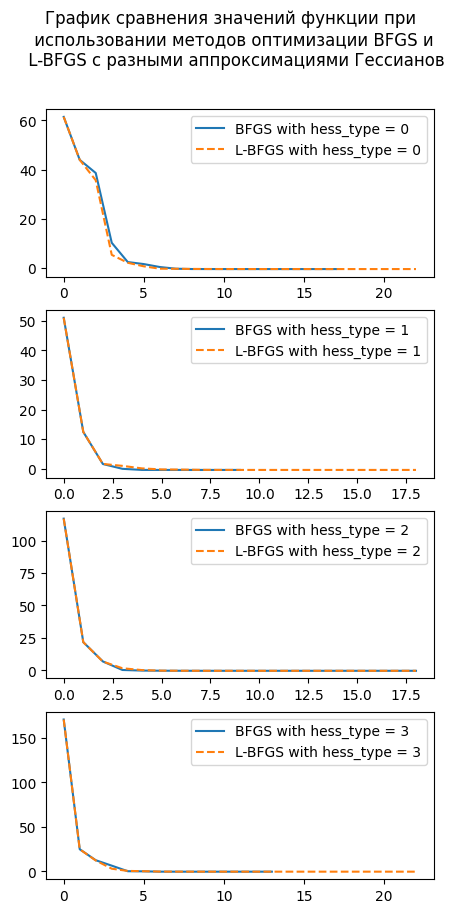

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(5, 10))
for hess_type in range(4):
    x = np.random.uniform(-10, 10, 3)
    x_bfgs, vals_bfgs = BFGS(x, func, count_deriv, hess_type=hess_type)
    x_lbfgs, vals_lbfgs = l_BFGS(x, func, count_deriv, hess_type=hess_type)
    axs[hess_type].plot(
        range(len(vals_bfgs)), vals_bfgs, label=f"BFGS with hess_type = {hess_type}"
    )
    axs[hess_type].plot(
        range(len(vals_lbfgs)),
        vals_lbfgs,
        label=f"L-BFGS with hess_type = {hess_type}",
        linestyle="dashed",
    )
    axs[hess_type].legend()

fig.suptitle(
    "График сравнения значений функции при \n использовании методов оптимизации BFGS и \n L-BFGS с разными аппроксимациями Гессианов"
)
plt.show()

Иногда L-BFGS требуется большего количества шагов, чтобы придти к оптимуму. Но зачастую L-BFGS лучше оптимизирует функцию на первых шагах

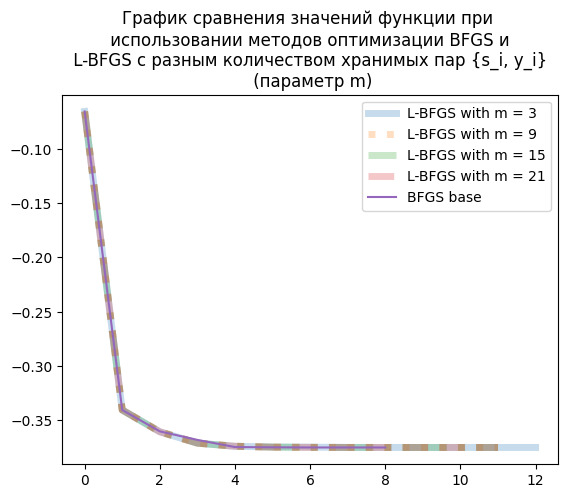

In [9]:
x = np.random.uniform(-0.5, 1, 3)
linestyles = ["solid", "dotted", "dashdot", "dashed"]
i = 0
for m in range(3, 22, 6):
    x_lbfgs, vals_lbfgs = l_BFGS(x, func, count_deriv, m=m)
    plt.plot(
        range(len(vals_lbfgs)),
        vals_lbfgs,
        label=f"L-BFGS with m = {m}",
        lw=5,
        alpha=0.25,
        linestyle=linestyles[i],
    )
    i += 1
x_bfgs, vals_bfgs = BFGS(x, func, count_deriv)
plt.plot(range(len(vals_bfgs)), vals_bfgs, label=f"BFGS base")
plt.legend()
plt.title(
    "График сравнения значений функции при \n использовании методов оптимизации BFGS и \n L-BFGS с разным количеством хранимых пар {s_i, y_i} \n (параметр m)"
)
plt.show()

Возможно отличия несущественны из-за простоты функции. На более сложных функциях отличия будут заметными